In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import jellyfish
import torch.nn.functional as F
import seaborn as sns
from collections import defaultdict
# Set random seed for reproducibility
np.random.seed(324)
torch.manual_seed(324)

# Create a small dataset: 1000 random binary vectors (16 bits each)
data_np = np.random.randint(0, 2, size=(1000, 64)).astype(np.float32)
data_tensor = torch.tensor(data_np)

len(data_tensor)


1000

In [34]:
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [35]:
# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, plaintext_dim, encoding_dim, ciphertext_dim,z_dim=100):
        super(Autoencoder, self).__init__()
        # Encoder: Compress input from 16 -> 8 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(plaintext_dim+z_dim, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.LeakyReLU(),
            nn.Linear(encoding_dim, ciphertext_dim),
            nn.BatchNorm1d(ciphertext_dim),
            nn.LeakyReLU(),
        )
        # Decoder: Reconstruct from 8 -> 16 dimensions
        self.decoder = nn.Sequential(
            nn.Linear(ciphertext_dim+z_dim, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.LeakyReLU(),
            nn.Linear(encoding_dim, plaintext_dim),
            nn.BatchNorm1d(plaintext_dim),
            nn.Sigmoid()  
        )
    
    def forward(self, x,z):
        x=torch.cat([x,z],dim=1)
        encoded = self.encoder(x)
        latent_ciphher=torch.cat([encoded, z], dim=1)
        decoded = self.decoder(latent_ciphher)
        return encoded, decoded

    def encode(self,x):
        return self.encoder(x)

    def decode(self,x):
        return self.decoder(x)

class CombinedLoss(nn.Module):
    def __init__(self, mse_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.mse = nn.MSELoss()
        self.mse_weight = mse_weight
        
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        mse_loss = self.mse(pred, target)
        return bce_loss + self.mse_weight * mse_loss

# Usage
criterion = CombinedLoss(mse_weight=0.5)
model = Autoencoder(plaintext_dim=64, encoding_dim=200,ciphertext_dim=100)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare DataLoader
dataset = TensorDataset(data_tensor, data_tensor)  # input and target are the same
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
x,y=next(iter(dataloader))
x.shape


torch.Size([32, 64])

In [36]:
# Train the autoencoder
num_epochs = 230
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        optimizer.zero_grad()
        B=batch_inputs.shape[0]
        z=torch.randn((B,100))*15
        encoded, outputs = model(batch_inputs,z)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_inputs.size(0)
    epoch_loss /= len(dataloader.dataset)
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")



Epoch [1/230], Loss: 0.9496
Epoch [50/230], Loss: 0.7246
Epoch [100/230], Loss: 0.4489
Epoch [150/230], Loss: 0.1865
Epoch [200/230], Loss: 0.0693


In [37]:
seed=1111111
np.random.seed(seed)
torch.manual_seed(seed)
data_np = np.random.randint(0, 2, size=(10000, 64)).astype(np.float32)
data_tensor = torch.tensor(data_np)
sample = data_tensor[0:1]  #
# sample=torch.randint(1,64)
# sample=torch.tensor([[1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.]])
model.eval()
with torch.no_grad():
    z=torch.randn((1,100))
    encoded_sample, reconstructed_sample = model(sample,z)


binary_reconstructed = (reconstructed_sample > 0.5).float()
print(torch.equal(sample,binary_reconstructed))
print("\nOriginal sample:")
print(sample)
print("\nEncoded (latent) representation (this is the 'encrypted' form):")
print(encoded_sample)
print("Reconstructed sample (continuous values):")
print(reconstructed_sample)
print("\nRounded (binary) reconstructed sample:")
print(binary_reconstructed)

True

Original sample:
tensor([[0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
         1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
         1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
         0., 1., 1., 0., 1., 0., 1., 0., 1., 1.]])

Encoded (latent) representation (this is the 'encrypted' form):
tensor([[ 4.1226e+00,  4.9435e+00, -9.5877e-03,  2.8047e+00,  4.3043e-01,
          4.4613e+00,  4.9587e+00,  2.4121e+00,  3.0301e+00,  1.1189e+01,
          3.8197e+00, -6.0058e-03, -6.3722e-03,  2.9138e+00,  2.2114e+00,
          3.6357e+00,  2.9379e+00, -1.1416e-02,  2.7039e+00,  1.1359e+00,
          1.3289e+00,  3.2963e+00,  4.9687e-01,  4.8761e+00,  5.5110e+00,
          2.7503e+00,  5.2441e+00,  2.6608e+00,  4.5130e+00,  4.8329e+00,
          2.0066e+00,  3.8139e+00,  3.7659e+00,  2.9165e+00,  4.2038e+00,
          1.5066e-01,  4.1189e+00,  3.8924e+00, -6.3216e-03,  1.6212e+00,
          3.8722e+00,  3.6

In [40]:
import torch

def binary_tensor_to_word(binary_tensor):
    """
    Converts a PyTorch tensor of shape (1, 64) containing binary digits (0 or 1)
    into an 8-character word by interpreting every 8 bits as one ASCII character.
    """
    # Ensure the tensor is 1-dimensional (flatten it)
    bits = binary_tensor.view(-1).tolist()  # This will be a list of 64 values
    
    # Convert every group of 8 bits to a character
    chars = []
    for i in range(0, 64, 8):
        # Get 8 bits for one character
        chunk = bits[i:i+8]
        # Convert the 8 bits into a string, e.g. [0,1,0,0,0,0,0,1] -> "01000001"
        bit_string = ''.join(str(int(b)) for b in chunk)
        # Convert the bit string to an integer (base 2)
        ascii_val = int(bit_string, 2)
        # Convert the integer to a character using the chr() function
        chars.append(chr(ascii_val))
    
    # Join the list of characters to form a word
    return ''.join(chars)


def word_to_binary_tensor(word):
    """
    Converts an 8-character word into a PyTorch tensor of shape (1, 64)
    containing binary digits (0 or 1) by representing each character in 8 bits.
    """
    if len(word) != 8:
        raise ValueError("The input word must be exactly 8 characters long.")
    
    bits_list = []
    for char in word:
        # Convert character to its ASCII value and then to an 8-bit binary string
        bin_str = format(ord(char), '08b')
        # Extend the list with each bit as an integer (0 or 1)
        bits_list.extend([int(bit) for bit in bin_str])
    
    # Convert the list to a PyTorch tensor and reshape to (1, 64)
    binary_tensor = torch.tensor(bits_list, dtype=torch.float32).view(1, 64)
    return binary_tensor

# Example: Create a tensor of shape (1, 64) representing the word "Hello!!!"
# Let's compute the binary representation for each character in "Hello!!!"




In [41]:
import torch
import random

word = "password"

# Convert word to binary tensor
binary_list = []
for char in word:
    binary_str = format(ord(char), '08b')
    binary_list.extend([int(bit) for bit in binary_str])
binary_tensor = torch.tensor([binary_list], dtype=torch.float32)

model.eval()

def binary_tensor_to_word(tensor):
    bits = tensor[0].tolist()
    chars = [chr(int("".join(str(int(bit)) for bit in bits[i:i+8]), 2)) for i in range(0, len(bits), 8)]
    return ''.join(chars)


ciphertexts = []
decoded_texts = []
hashm={}
# Generate 10 ciphertexts and decoded outputs
for i in range(10):
    z = torch.randn((1, 100)) * 15
    with torch.no_grad():
        encoded_sample, reconstructed_sample = model(binary_tensor, z)
        binary_reconstructed = (reconstructed_sample > 0.5).float()
        thresh = [encoded_sample.std(), encoded_sample.mean()]
        threshold = random.choice(thresh)
        encoded_word = binary_tensor_to_word(((encoded_sample) > threshold).float())
        decoded_word = binary_tensor_to_word(binary_reconstructed)
        hashm[i]=encoded_sample
    
    ciphertexts.append(encoded_word)
    decoded_texts.append(decoded_word)

print("--------------------------------------------------")
print(f"Original Word: {word}")

# Print remaining results and calculate D-L distance relative to the first
for i in range(0, 10):
    dl_distance = jellyfish.damerau_levenshtein_distance(ciphertexts[i], decoded_texts[i])
    print(f"[{i+1}] Ciphertext: {ciphertexts[i]} | Decoded: {decoded_texts[i]} | D-L distance from [1]: {dl_distance}")
    
print("--------------------------------------------------")
for i in range(0, 10):
    if(i==9):
         dl_distance = jellyfish.damerau_levenshtein_distance(ciphertexts[i], ciphertexts[0])
         
         
    else:
        dl_distance = jellyfish.damerau_levenshtein_distance(ciphertexts[i], ciphertexts[i+1])
        
    print(f"[{i+1}] Ciphertext: {ciphertexts[i]} | Decoded: {decoded_texts[i]} | D-L distance from [1]: {dl_distance}")
    
print("--------------------------------------------------")
for i in range(0, 10):
    if(i==9):
         print((F.cosine_similarity(hashm[i],hashm[0])))
    else:
        print((F.cosine_similarity(hashm[i],hashm[i+1])))
                                                        
    
                                                                              
                                                                    
    
all_correct = all(decoded == word for decoded in decoded_texts)
print("All reconstructions correct:", all_correct)


--------------------------------------------------
Original Word: password
[1] Ciphertext: ¿ÔÝK>¡îÑ@ | Decoded: password | D-L distance from [1]: 13
[2] Ciphertext: ¿ÔÝ6¡êSQA | Decoded: password | D-L distance from [1]: 13
[3] Ciphertext: ÿÕýOþ¡þûÝA | Decoded: password | D-L distance from [1]: 13
[4] Ciphertext: ½ÄÝJ>¡nóQA | Decoded: password | D-L distance from [1]: 13
[5] Ciphertext: ¿ÄÝ
6¡n3Q@ | Decoded: password | D-L distance from [1]: 13
[6] Ciphertext: ýÕýK¾¡îûÕE | Decoded: password | D-L distance from [1]: 13
[7] Ciphertext: ¿Õýkö¡þóÝA | Decoded: password | D-L distance from [1]: 13
[8] Ciphertext: ½ÄÝ	>¡î³ÑA | Decoded: password | D-L distance from [1]: 13
[9] Ciphertext: ¿ÔÝ>¡n3QA | Decoded: password | D-L distance from [1]: 13
[10] Ciphertext: ÿÕýK¾¥îûÝA | Decoded: password | D-L distance from [1]: 13
--------------------------------------------------
[1] Ciphertext: ¿ÔÝK>¡îÑ@ | Decoded: password | D-L distance from [1]: 9
[2] Ciphertext: ¿ÔÝ6¡êS

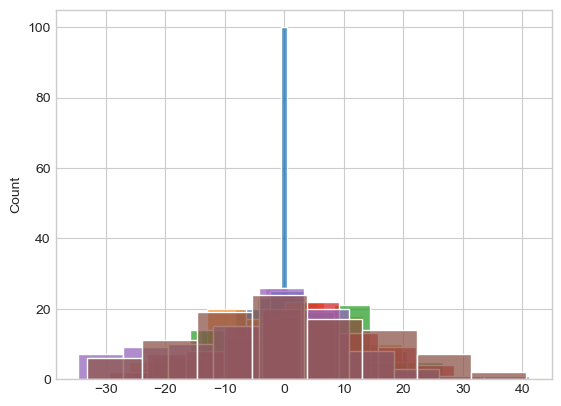

In [42]:
for i in range(16):
    z = torch.randn((1, 100)) * i
    
    sns.histplot(data=z[0].numpy())

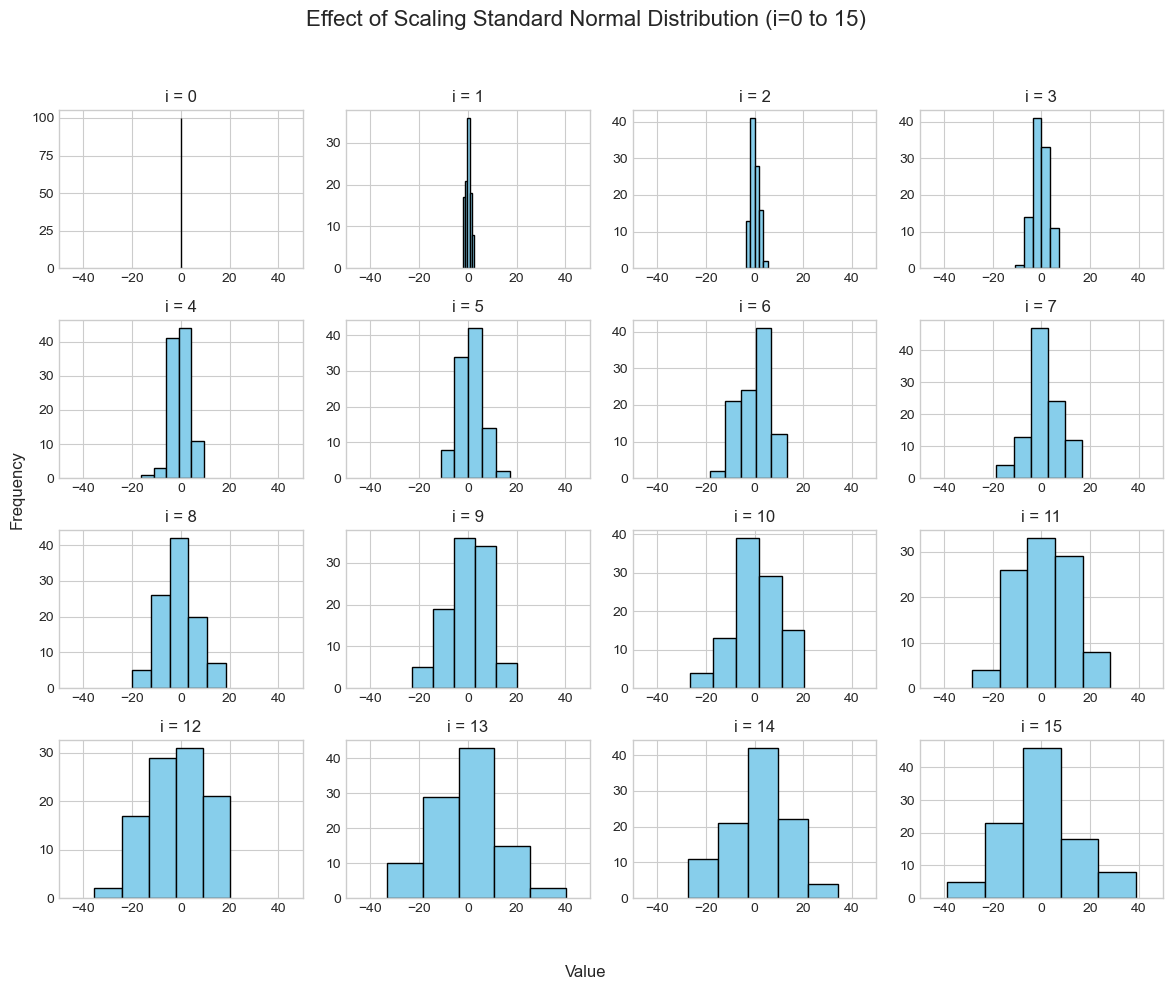

<Figure size 640x480 with 0 Axes>

In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math # For potential future use, not strictly needed here

# --- Research Paper Styling Suggestions ---
# 1. Use a professional Matplotlib style
#    'seaborn-v0_8-whitegrid' is clean and often good for papers.
#    'ggplot' is another option.
#    'science' style (requires pip install scienceplots) is specifically
#    designed for scientific papers. Let's use 'seaborn-v0_8-whitegrid' as a default.
plt.style.use('seaborn-v0_8-whitegrid')

# 2. Choose appropriate figure size for a paper
#    This might need adjustment based on journal requirements.
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 10)) # 4x4 grid for 16 plots
axes = axes.flatten() # Flatten the 4x4 array of axes objects to easily iterate

# 3. Consistent X-axis Range
#    As 'i' increases, the data spreads out significantly.
#    To compare the spread, you need a consistent x-axis limit across all plots.
#    For i=15, the data std dev is ~15. Most data will be within [-45, 45] (3 std dev).
#    Let's set a slightly wider range.
x_limit = 50 # Max absolute value on x-axis

# 4. Consistent number of bins
#    You specified bins=5. We will keep this consistent.

# --- Generate and Plot Histograms ---
num_i_values = 16 # i from 0 to 15

for i in range(num_i_values):
    # Calculate which subplot to use
    ax = axes[i]

    # Generate data: mean 0, std dev proportional to i (variance i^2)
    # Note: For i=0, z will be all zeros.
    z = torch.randn((1, 100)) * i

    # Plot the histogram on the current subplot axis
    # Add edgecolor for better bar separation with few bins
    ax.hist(z[0].numpy(), bins=5, color='skyblue', edgecolor='black')

    # Set title for each subplot indicating the value of i
    ax.set_title(f'i = {i}')

    # Ensure consistent x-axis limits for comparison
    ax.set_xlim([-x_limit, x_limit])

    # Optional: Hide y-axis labels for cleaner look if only shape matters,
    # but keeping them shows the count distribution within fixed bins.
    # ax.set_yticks([])

# --- Add overall figure labels and title ---
# Use suptitle for overall title, and sup(x/y)label for overall axis labels
fig.suptitle('Effect of Scaling Standard Normal Distribution (i=0 to 15)', fontsize=16)
fig.supxlabel('Value', fontsize=12)
fig.supylabel('Frequency', fontsize=12)

# --- Adjust layout and display ---
# 5. Use tight_layout to prevent labels/titles from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle

# 6. Display the plot
plt.show()
plt.savefig('normaldist.png', bbox_inches='tight')

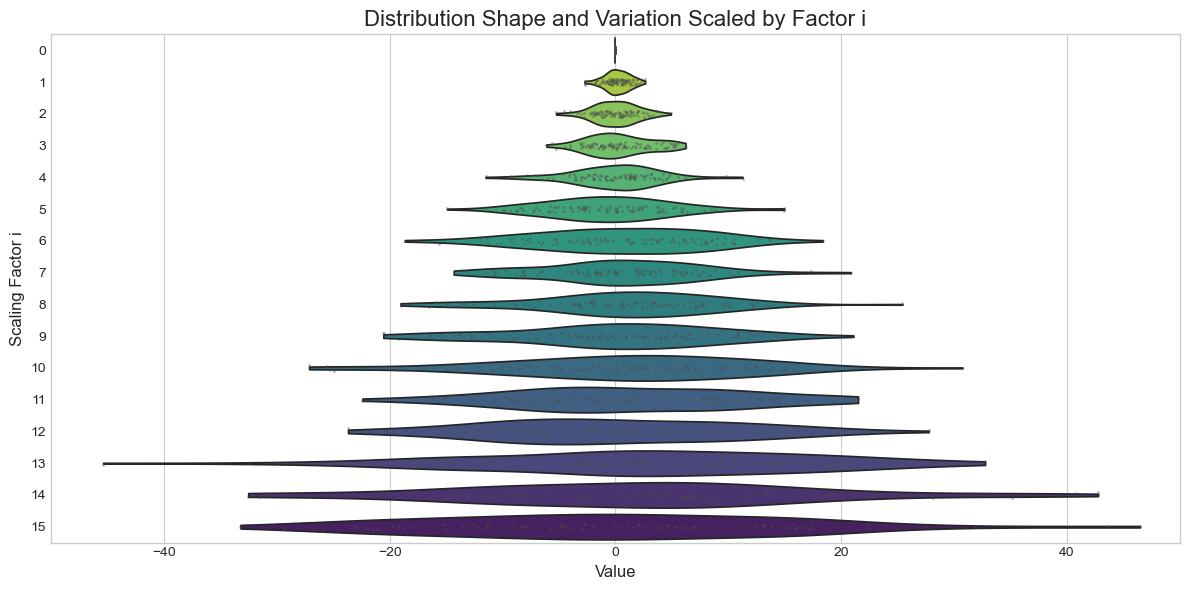

In [44]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # seaborn works well with pandas DataFrames
import seaborn as sns # For violin plot and stripplot

# --- Styling for Research Papers ---
# Use a professional seaborn style. 'seaborn-v0_8-whitegrid' or 'seaborn-v0_8-darkgrid'
# are good choices. They handle colors, grids, etc., well.
sns.set_style('whitegrid') # Or 'darkgrid'
# You can also set a specific color palette
# sns.set_palette('viridis') # Example palette

# --- Parameters ---
num_i_values = 16       # i from 0 to 15
num_data_points = 100   # Number of data points for each distribution

# Determine a consistent x-axis range for comparison
# Data spread is roughly i * 3 (3 standard deviations). Max i=15, so max spread ~45.
# Use a range slightly wider than this.
x_limit = 50

# --- Generate and Structure Data ---
# Create lists to store data and their corresponding 'i' values
data_values = []
data_indices_i = []

for i in range(num_i_values):
    # Generate data: mean 0, std dev proportional to i
    # Note: For i=0, z will be all zeros.
    z = torch.randn((1, num_data_points)) * i
    data = z[0].numpy()

    # Append the data points and the corresponding i value
    data_values.extend(data)
    data_indices_i.extend([str(i)] * num_data_points) # Store i as string for categorical plot

# Create a pandas DataFrame from the collected data
df = pd.DataFrame({
    'Value': data_values,
    'Scaling Factor i': data_indices_i
})

# --- Create Figure ---
# Adjust figure size for clarity. Wider often works well for comparing distributions.
plt.figure(figsize=(12, 6)) # Width x Height

# --- Plot Violin Plots and Stripplot ---
# Use the data from the DataFrame

# Plot Violin plots: Shows the distribution shape (density)
# 'x' is the value, 'y' is the category ('i')
# 'orient='h'' makes the violins horizontal, with 'i' on the y-axis, which is more intuitive
# for comparing spread along the x-axis.
violin_plot = sns.violinplot(x='Value', y='Scaling Factor i', data=df,
                             cut=0, # Cut off violins at the data range limits
                             inner=None, # Hide default inner quartiles/median lines
                             palette='viridis_r') # Use a color palette, reversed to have high i brighter

# Overlay a Stripplot: Shows the individual data points
# Alpha makes points semi-transparent to show density where they overlap
# Color '0.3' is a dark grey
strip_plot = sns.stripplot(x='Value', y='Scaling Factor i', data=df,
                           size=2, color='0.3', alpha=0.4)


# --- Configure Axes and Titles ---
# Set consistent x-limits for clear comparison of spread
plt.xlim([-x_limit, x_limit])

# Add informative title and labels
plt.title('Distribution Shape and Variation Scaled by Factor i', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Scaling Factor i', fontsize=12)


# --- Improve Layout ---
plt.tight_layout()

# --- Display Plot ---
plt.show()

In [45]:
l1={}
listo=[5,15,30,40,100]
for i in listo:
    z = torch.randn((1, 100)) * i
    encoded_sample, reconstructed_sample = model(binary_tensor, z)
    l1[i]=(encoded_sample)
    

In [46]:
for i in range(4):
    if(i==3):
         print((F.cosine_similarity(listo[i],listo[0])))
    else:
        print((F.cosine_similarity(listo[i],listo[i+1])))

TypeError: cosine_similarity(): argument 'x1' (position 1) must be Tensor, not int

In [47]:



for i in range(len(listo)):
    if(i==len(listo)-1):
         break
    else:
        print((F.cosine_similarity(l1[listo[i]],l1[listo[i+1]])))

tensor([0.9940], grad_fn=<SumBackward1>)
tensor([0.9849], grad_fn=<SumBackward1>)
tensor([0.9504], grad_fn=<SumBackward1>)
tensor([0.8687], grad_fn=<SumBackward1>)


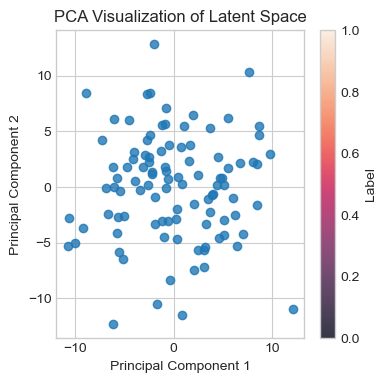

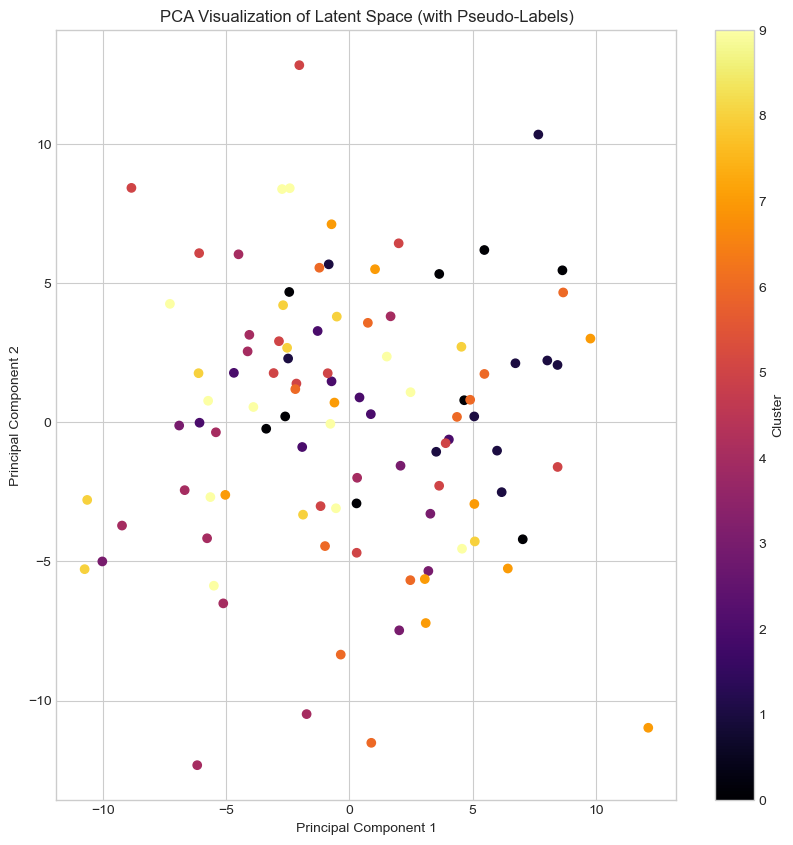

In [49]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)
x,y=next(iter(dataloader))
model.eval()
with torch.no_grad():
    z=torch.randn((100,100))*5
    # print(z)
    encoded_sample, reconstructed_sample = model(x,z)

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# PCA reduction to 2 components
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(encoded_sample) 
plt.figure(figsize=(4, 4))
scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], cmap='viridis', alpha=0.8);
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Latent Space')
plt.colorbar(scatter, label='Label')
plt.show()
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
pseudo_labels = kmeans.fit_predict(encoded_sample)

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(encoded_sample)
plt.figure(figsize=(10, 10))
scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=pseudo_labels, cmap='inferno', alpha=1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Latent Space (with Pseudo-Labels)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- SIMULATE encoded_sample FOR TESTING ---
# In a real scenario, encoded_sample would come from your autoencoder or other model
# For demonstration, let's create some dummy data with clear clusters
# This ensures the code is runnable standalone for testing.
np.random.seed(42)
# Create 7 distinct clusters in 2D for PCA to "find"
# To make it more realistic for `encoded_sample` which would be higher dimensional,
# let's create higher dimensional data first, then PCA will reduce it.
n_features_original = 10 # Example original feature dimension
n_samples_per_cluster = 50
num_clusters_data = 7

centers = np.random.rand(num_clusters_data, n_features_original) * 20 - 10 # Spread out centers
encoded_sample_list = []
for i in range(num_clusters_data):
    # Create somewhat spherical clusters in the original high-D space
    cluster_data = np.random.multivariate_normal(
        centers[i],
        np.eye(n_features_original) * (np.random.rand() * 2 + 0.5), # Varying covariance
        size=n_samples_per_cluster
    )
    encoded_sample_list.append(cluster_data)
encoded_sample = np.vstack(encoded_sample_list)
# --- END SIMULATION OF encoded_sample ---


# Define the number of clusters
num_clusters = 7
# Ensure n_init is set for newer scikit-learn versions
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
pseudo_labels = kmeans.fit_predict(encoded_sample)

# Reduce dimensions for visualization using PCA
# Added random_state for reproducibility
pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(encoded_sample)

plt.figure(figsize=(20, 20))

# --- Start of Modifications (from original script) ---

# Get unique cluster labels
unique_labels = np.unique(pseudo_labels)

# Define a list of distinct colors (using a qualitative colormap)
# 'tab10' provides 10 distinct colors, suitable for num_clusters=10
# For num_clusters=7, 'viridis', 'plasma', 'cividis', 'tab10', 'Set1', 'Set2', 'Paired' are good choices.
# Let's ensure we get enough distinct colors if len(unique_labels) is high.
if len(unique_labels) <= 10:
    colors_cmap_name = 'tab10'
elif len(unique_labels) <= 20:
    colors_cmap_name = 'tab20'
else: # Fallback or use a continuous map if too many clusters for qualitative
    colors_cmap_name = 'viridis'

colors = plt.cm.get_cmap(colors_cmap_name, len(unique_labels))


# Define a list of distinct markers (shapes)
# You'll need at least as many distinct markers as clusters
markers = ['o', 's', '^', 'v', 'D', 'P', 'X', '*', '<', '>'] # Example markers

# Ensure we have enough markers, repeat if necessary
# For num_clusters=7, the above list is sufficient.
# If num_clusters > len(markers), uncomment the line below to cycle markers:
if len(unique_labels) > len(markers):
    markers = (markers * (len(unique_labels) // len(markers) + 1))[:len(unique_labels)]


# Iterate through each unique cluster label and plot points belonging to that cluster
for i, cluster_label in enumerate(unique_labels):
    # Select data points for the current cluster
    cluster_points = latent_pca[pseudo_labels == cluster_label]

    # Select the color and marker for this cluster
    cluster_color = colors(i) # Get color from the colormap
    cluster_marker = markers[i % len(markers)] # Get marker from the list, cycling if needed

    # Plot these points with the specific color and marker
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        color=cluster_color,
        marker=cluster_marker,
        label=f'Cluster {cluster_label}', # Add a label for the legend
        alpha=1 # Keep original alpha
    )

# --- End of Modifications (from original script) ---

# --- FONT SIZE MODIFICATIONS ---
title_fontsize = 24         # Font size for the main plot title
label_fontsize = 18         # Font size for x and y axis labels
legend_title_fontsize = 16  # Font size for the legend title
legend_items_fontsize = 12  # Font size for the individual legend items/labels

plt.xlabel('Principal Component 1', fontsize=label_fontsize)
plt.ylabel('Principal Component 2', fontsize=label_fontsize)
plt.title('PCA Visualization of Latent Space (by Cluster)', fontsize=title_fontsize)

# Add a legend to show which shape/color corresponds to which cluster
plt.legend(title='Clusters', loc='best', title_fontsize=legend_title_fontsize, fontsize=legend_items_fontsize)
# --- END FONT SIZE MODIFICATIONS ---


# The original colorbar is not needed when using discrete colors and shapes explained by the legend
# plt.colorbar(scatter, label='Cluster') # Remove this line
plt.savefig('visualizations.png', bbox_inches='tight')
plt.grid(True, linestyle='--', alpha=0.6) # Optional: add a grid
plt.show()